In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
!pip install PySpark

  Created wheel for PySpark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845519 sha256=93f7a80adbea4ded5dbef3f687013cb29653905598041bdc3bbd7ea8b2e74dfd
  Stored in directory: c:\users\blabl\appdata\local\pip\cache\wheels\43\dc\11\ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built PySpark


In [8]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [9]:
spark = SparkSession.builder.appName("Titanic Data Analysis").getOrCreate()

In [10]:
train_df = spark.read.csv("train.csv", header=True, inferSchema=True)

In [11]:
train_df.agg(mean("Fare")).show()

+----------------+
|       avg(Fare)|
+----------------+
|32.2042079685746|
+----------------+



In [12]:
train_df.groupBy("Sex").agg(mean("Fare")).show()

+------+------------------+
|   Sex|         avg(Fare)|
+------+------------------+
|female| 44.47981783439487|
|  male|25.523893414211418|
+------+------------------+



In [13]:
train_df = train_df.na.fill(train_df.agg(mean("Age")).first()[0], "Age")
train_df.summary().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               891|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null|29.699117647058763|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [14]:
train_df.select("Embarked").distinct().count()
# how many distinct values in Embarked

4

In [15]:
1 - (train_df.select("Age").dropna().count() / train_df.count())
# no missing age because we filled it

0.0

In [16]:
train_df.stat.corr("Fare", "Survived")
# correlation between each item

0.2573065223849626

In [17]:
train_df.describe("Age").show()
# let's describe a feature

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               891|
|   mean|29.699117647058763|
| stddev|13.002015226002891|
|    min|              0.42|
|    max|              80.0|
+-------+------------------+



In [18]:
train_df.select("Name").distinct().count()
# let's check a potentially high cardinality column using distinct count
# we have 891 targets as was expected

891

In [19]:
train_df.groupBy("Embarked").count().sort(desc("count")).show()
# showing all Embarked features then counting it descending

+--------+-----+
|Embarked|count|
+--------+-----+
|       S|  644|
|       C|  168|
|       Q|   77|
|    null|    2|
+--------+-----+



In [20]:
# let's do some sql stuff on it
# first let's register the df as a temporary sql table
train_df.createOrReplaceTempView("train")

In [21]:
spark.sql("SELECT count(*) FROM train WHERE Sex = 'male'").show()
# for example we have 577 male passengers

+--------+
|count(1)|
+--------+
|     577|
+--------+



In [22]:
spark.sql("SELECT Pclass, AVG(Age) FROM train GROUP BY Pclass").show()

+------+------------------+
|Pclass|          avg(Age)|
+------+------------------+
|     1| 37.04811819172115|
|     3|26.403258655804464|
|     2|  29.8669581202046|
+------+------------------+



In [23]:
spark.sql("SELECT Name, Fare FROM train ORDER BY Fare DESC").show()

+--------------------+--------+
|                Name|    Fare|
+--------------------+--------+
|Lesurer, Mr. Gust...|512.3292|
|Cardeza, Mr. Thom...|512.3292|
|    Ward, Miss. Anna|512.3292|
|Fortune, Miss. Al...|   263.0|
|   Fortune, Mr. Mark|   263.0|
|Fortune, Mr. Char...|   263.0|
|Fortune, Miss. Ma...|   263.0|
|"Ryerson, Miss. S...| 262.375|
|Ryerson, Miss. Em...| 262.375|
|Baxter, Mr. Quigg...|247.5208|
|Baxter, Mrs. Jame...|247.5208|
| Robbins, Mr. Victor| 227.525|
|Astor, Mrs. John ...| 227.525|
|Endres, Miss. Car...| 227.525|
|Bidois, Miss. Ros...| 227.525|
|  Farthing, Mr. John|221.7792|
|Widener, Mr. Harr...|   211.5|
|Madill, Miss. Geo...|211.3375|
|Allen, Miss. Elis...|211.3375|
|Robert, Mrs. Edwa...|211.3375|
+--------------------+--------+
only showing top 20 rows



In [24]:
# let's create some random visualizations using sql api and seaborn
# maybe let's try to show correlations between items even...
filtered_df = spark.sql("SELECT * FROM train WHERE Fare > 20 AND Age > 30")

In [25]:
filtered_pd = filtered_df.toPandas()
# we then need to convert it back to pandas

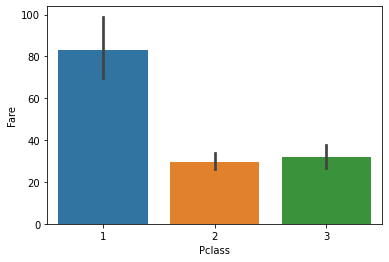

In [26]:
import seaborn as sns
sns.barplot(x='Pclass', y='Fare', data=filtered_pd)

In [27]:
filtered_df = spark.sql("SELECT * FROM train WHERE Fare > 20 AND Age > 30")
# another filter to get table where Fare is greater than 20 and Age is greater 
#than 30

In [28]:
filtered_pd = filtered_df.toPandas()
#Convert the filtered DataFrame to a pandas DataFrame:

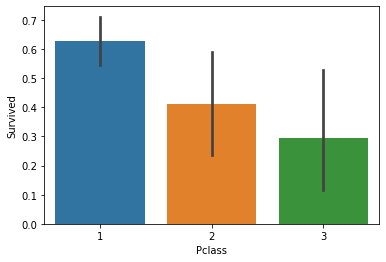

In [29]:
sns.barplot(x='Pclass', y='Survived', data=filtered_pd)
#Use Seaborn to create visualizations that demonstrate 
#the correlation between survival and other variables

In [30]:
# to look for correlations other ways you can use smth like pandas crosstab
pd.crosstab(filtered_pd.Sex, filtered_pd.Survived, margins=True)

Survived,0,1,All
Sex,,,
female,9,65,74
male,68,30,98
All,77,95,172
